<a href="https://colab.research.google.com/github/CosmoStat/Tutorials/blob/tensorflow-tutorial/TensorFlowFirstSteps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 Francois Lanusse, Zaccharie Ramzi

Licensed under the Apache License, Version 2.0 (the "License");


# First steps with TensorFlow

Authors: [@EiffL](https://github.com/EiffL) (Francois Lanusse), [@zaccharieramzi](https://github.com/zaccharieramzi) (Zaccharie Ramzi)

## Overview

In this short notebook, we will review the basics of TensorFlow, how to write a computational graph, compute gradients by automatic differentiation, and perform optimization. This introduction is intended for first time TensorFlow users, and can be safely disregarded by experienced users.  
**Note**: we only consider TensorFlow 2.x here.

### Learning goals

In this notebook, we will learn:
  - Core principles of TensorFlow
  - How to write a computational graph
  - How to compute gradients
  - How to perform optimization

## What is a Tensor?

Let us get started with a minimal example:

In [0]:
import numpy as np
import tensorflow as tf

x = tf.zeros(shape=[8])

This code is pretty much self explanatory, we have defined an object x to be an "array" of zeros of size 16. Let's take a closer look at this object:

In [2]:
x

<tf.Tensor: shape=(8,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

We see that this object is in fact a TensorFlow Tensor, characterized by:
  - A shape, e.g. (8,)
  - A type: noted as `dtype`, here by default a single precision float i.e. `float32`, but types include `int32`, `float64`, `complex64`, etc.

**TODO**: explain that tensors are abstract objects, not values

**TODO**: explain why float32 is default

In addition, we see that this tensor has an assigned value, denoted by a numpy array, filled with zeros in this instance. 

**TODO**: explain that if we see a value it's because of eager execution


A numpy array can be converted into a TensorFlow tensor and vice-versa easily using the `tf.convert_to_tensor` function and `.numpy()` member of Tensor objects:

In [3]:
# Define a numpy array:
x = np.array( [1., 2., 3., 4.])

# Convert it into a tensor:
a = tf.convert_to_tensor( x )

# Inspect Tensor a:
a

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([1., 2., 3., 4.])>

In [4]:
# Convert back this tensor into a numpy array
y = a.numpy()

# Inspect array y:
y

array([1., 2., 3., 4.])

## Defining computational graphs

Now that we have introduced the notion of Tensors, let's learn about the Flow part :-) 

TensorFlow defines computations in terms of simple **operations** (`ops` for short) which can manipulate, create, or destroy tensors. These `ops`can be stringed together into a computational graph in order to perform complex operations.

Let us consider a very simple computation: $y = a * x + b$  
In the general case `y`, `a`, `y`, and `b` are all tensors, and the fundamental `ops` needed here are `add` and `multiply`. Here is how the computational graph would look like:
```
                              a          x
                               \        /
                               [multiply]
                                   |      b         
                                   \     /
                                    [add]
                                      |
                                      y
```
writing this computation in tensorflow is extremely simple:

In [0]:
# Let's introduce the input tensors
a = tf.ones(shape=(4,))
b = tf.zeros(shape=(4,))
x = tf.convert_to_tensor(np.array([1., 2., 3., 4.]), dtype=tf.float32)

# And here we define the computation
y = a * x + b

In [8]:
y

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1., 2., 3., 4.], dtype=float32)>

Feel free to experiment with the code above, in particular, try changing the shape or dtypes of the input tensors, what happens?

Because TF 2 uses eager execution, everything seems to happen at once, and it is not clear when the graph is created and executed. 

It is possible to define explicitly a graph that will be executed in one piece, i.e. without costly back and forth between python and GPU code using the `tf.function` decorator. Consider this example:

In [0]:
def affine_transform(x, a, b):
  return a * x + b

In [10]:
affine_transform(1 , 2 , 3)

5

This is pure Python code, and return a Python integer. No TensorFlow is involved here at all.

Now let's add the `@tf.function` decorator and see what happens:

In [0]:
@tf.function
def affine_transform(x, a, b):
  return a * x + b

In [12]:
affine_transform(1 , 2 , 3)

<tf.Tensor: shape=(), dtype=int32, numpy=5>

We see that this function now returns a tensor, despite being provided pure Python integer.

**TODO**: the magic of autograph

## Computing gradients

The most important part of TensorFlow is **automatic differentation**, this is of course at the heart of deep learning but is also a game changer for many applications.

As we have seen in the previous section, a TensorFlow computation is in fact a graph of operations and tensors. This symbolic representation of the computation allows TensorFlow in particular to compute gradients of tensors with respect to other tensors in the graph, using the **chain rule**.

If $y = a * x + b$ as in the previous example, we can also write it in terms of fundamental `ops` in the form:
$$ y = u + b \qquad u = a * x $$
 then:
$$\frac{\partial y}{\partial x} = \frac{\partial y}{\partial u} \frac{ \partial u}{\partial x} = 1 \times a = a$$  
All we need in order to compute the  gradients of any tensors with respect to any other tensor in the graph, is the expression of the $\frac{\partial f}{\partial x}$ for each `op` $f$, this is exactly what TensorFlow provides!  
Almost all TensorFlow operations have an associated gradient, and can be backpropagated through. This is example was trivial, but in the case of a neural network, there can be hundreds of `ops` in this gradient computation by the chain rule, and it's no problem.


What this means for you is that you only need to write down the forward model, and you get gradients for free.

Let's try it out with a simple matrix operation:

In [0]:
# Let's build a random orthogonal matrix
A = np.random.randn(64, 64)
A,_ = np.linalg.qr(A.T.dot(A)) # We make it nice and orthogonal ;-)

# Define a true input vector
x_t = np.zeros(64)
x_t[[16,32]] =1.0

# Compute some observations
y = A.dot(x_t)

Populating the interactive namespace from numpy and matplotlib


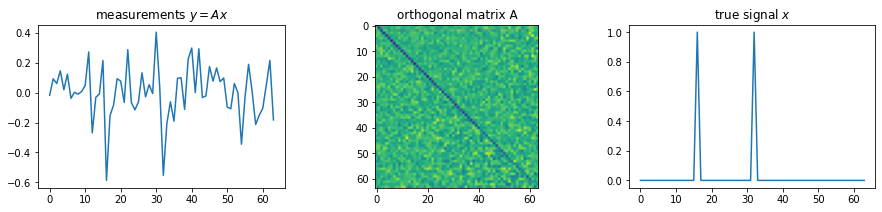

In [182]:
#@title Plotting

%pylab inline
figure(figsize=(15,3))
subplot(131)
plot(y)
title(r'measurements $y = A x$')
subplot(132)
imshow(A)
title(r'orthogonal matrix A')
subplot(133)
plot(x_t)
title(r'true signal $x$');

A typical task in this  instance is to compute an $\ell_2$ data fidelity term of the form:

$$ l = \frac{1}{2} \parallel y - A x \parallel_2^2 $$

and then try to optimize the value of $x$ as to minimize this loss. For  this, we need the gradients $\frac{\partial l}{\partial x}$. Classically, this would have to be computed by hand, and we would obtain analytically that:

$$ \frac{\partial l}{\partial x} = A^t (y - A x) $$

One would then have to write down this expression in numpy:

In [0]:
def loss(x, y, A):
  return 0.5 * np.sum( (y - A.dot(x))**2 )

def grad_loss(x, y, A):
  return - A.T.dot(y - A.dot(x))

# Let's define a first random guess solution x
x = np.random.randn(64)
l = loss(x, y, A)
dl_dx = grad_loss(x, y, A)

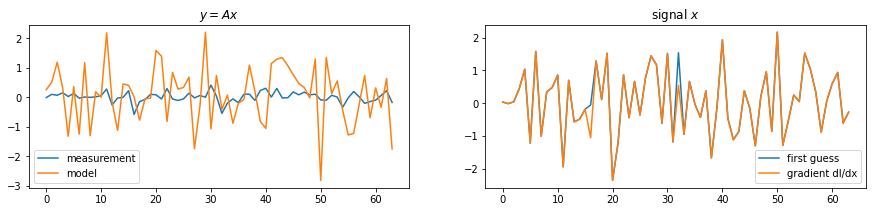

In [184]:
#@title Plotting

figure(figsize=(15,3))
subplot(121)
plot(y, label='measurement')
plot(A.dot(x), label='model')
title(r'$y = A x$')
legend()
subplot(122)
plot(x, label='first guess')
plot(dl_dx, label='gradient dl/dx')
title(r'signal $x$');
legend()

In [196]:
# Now, let's try to do the same thing in tensorflow
@tf.function
def loss(x, y, A):
  return 0.5 * tf.reduce_sum( (y - tf.linalg.matvec(A, x))**2 )

# Define a TF tensor using the numpy guess
x_tf = tf.convert_to_tensor(x)

with tf.GradientTape() as g:
  # Tell TF to keep and eye on this tensor
  g.watch(x_tf)

  # Compute the loss
  l_tf = loss(x_tf, y, A)

  # Request gradient with respect to x
  dl_dx_tf = g.gradient(l_tf, x_tf)

print("Loss computed by numpy: %0.5f ; loss computed by tensorflow: %0.5f"%(l, l_tf))

Loss computed by numpy: 32.56876 ; loss computed by tensorflow: 30.66844


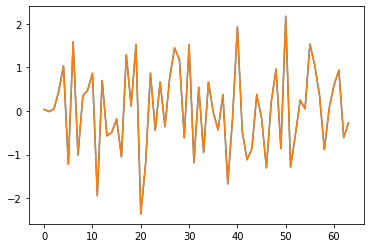

In [197]:
plot(dl_dx);
plot(dl_dx_tf);

## Optimization

Now that we know how to compute gradients, we can use them for solving problems
by gradient descent.

Here we introduce the notion of variable. A variable, contrary to a regular tensor, stores a persistent value in the graph and can be updated. Typically, variables will be used for the part of the graph you want to optimize.


In [0]:
x_var = tf.Variable(x)

In [0]:
with tf.GradientTape() as g:
  # Compute the loss
  l = loss(x_var, y, A)
  
  # Get the gradients
  dl_dx = g.gradient(l, x_var)

  # We can update the value of the variable like so
  x_var.assign_sub(dl_dx)

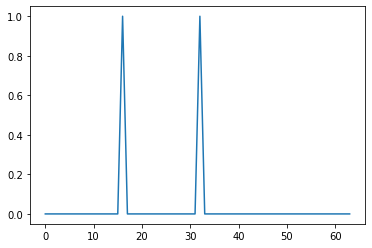

In [217]:
plot(x_var.numpy());

Because optimizers can get complicated and keeping track of all variables tedious, instead of doing things manually, it's often a great idea to use TensorFlow optimizers, which are typically used for neural networks.

In [218]:
# Define an optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1)

# Perform one iteration of the optimizer
optimizer.minimize( lambda : loss(x_var, y, A), [x_var])

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

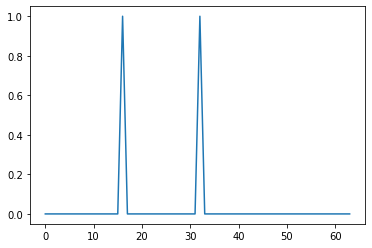

In [219]:
plot(x_var.numpy());